Chose any dataset that is small. We have to compare freezing layers vs not freezing base model layers, how does it impact transfer learning ,according to the dataset what is your conclusion,should you unfreeze or freeze.

1. Use Freezing
2. Use unfreezing
3. Train for about upto 10 epochs in each condition
4. Then decision

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = '/kaggle/input/alzheimers-adni/Alzheimers-ADNI/test'
TEST_DIR = '/kaggle/input/alzheimers-adni/Alzheimers-ADNI/train'

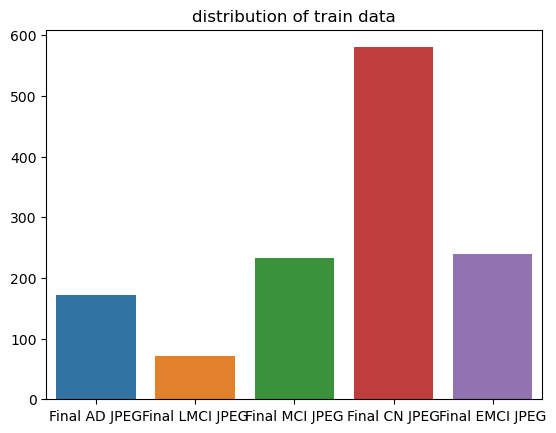

1296


In [3]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)

In [4]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

In [5]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 2061 images belonging to 5 classes.
Found 514 images belonging to 5 classes.
Found 16200 images belonging to 5 classes.


In [6]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
print(base_model.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

Freezing the weights of the pre-trained layers

In [7]:
for layer in base_model.layers:
    layer.trainable = False

Adding new layers on top of the pre-trained model dynamically

In [8]:
input = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(input, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(input, output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [9]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [10]:
h = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 77s 3s/step - loss: 2.5015 - accuracy: 0.4355 - val_loss: 2.2672 - val_accuracy: 0.1198
Epoch 2/10
27/27 [==============================] - 74s 3s/step - loss: 1.2713 - accuracy: 0.4698 - val_loss: 1.6640 - val_accuracy: 0.2188
Epoch 3/10
27/27 [==============================] - 74s 3s/step - loss: 1.0535 - accuracy: 0.4828 - val_loss: 1.7137 - val_accuracy: 0.3490
Epoch 4/10
27/27 [==============================] - 75s 3s/step - loss: 0.9554 - accuracy: 0.5337 - val_loss: 1.8330 - val_accuracy: 0.2865
Epoch 5/10
27/27 [==============================] - 75s 3s/step - loss: 1.0267 - accuracy: 0.4907 - val_loss: 1.9536 - val_accuracy: 0.2500
Epoch 6/10
27/27 [==============================] - 76s 3s/step - loss: 0.9297 - accuracy: 0.5266 - val_loss: 1.9145 - val_accuracy: 0.2812
Epoch 7/10
27/27 [==============================] - 77s 3s/step - loss: 0.9182 - accuracy: 0.5255 - val_loss: 2.2933 - val_accuracy: 0.4271
Epoch 8/10
27/27 [==

Unfreezing the weights of last 8 layers of the pre-trained VGG16 model to train them along with the new layers

In [11]:
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [12]:
print(f"VGG16- number of layers: {len(base_model.layers)}")
for layer in base_model.layers:
    print(f"{layer.name} trainable? {layer.trainable}")

VGG16- number of layers: 19
input_1 trainable? False
block1_conv1 trainable? False
block1_conv2 trainable? False
block1_pool trainable? False
block2_conv1 trainable? False
block2_conv2 trainable? False
block2_pool trainable? False
block3_conv1 trainable? False
block3_conv2 trainable? False
block3_conv3 trainable? False
block3_pool trainable? False
block4_conv1 trainable? True
block4_conv2 trainable? True
block4_conv3 trainable? True
block4_pool trainable? True
block5_conv1 trainable? True
block5_conv2 trainable? True
block5_conv3 trainable? True
block5_pool trainable? True


In [13]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics= ['accuracy']
)

In [14]:
h1 = model.fit(
    train_batch,
    steps_per_epoch = 883 // BATCH_SIZE,
    validation_data = valid_batch,
    validation_steps = 218 // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
27/27 [==============================] - 133s 5s/step - loss: 3.7928 - accuracy: 0.4130 - val_loss: 1.2966 - val_accuracy: 0.4583
Epoch 2/10
27/27 [==============================] - 134s 5s/step - loss: 1.1695 - accuracy: 0.4537 - val_loss: 1.5156 - val_accuracy: 0.4635
Epoch 3/10
27/27 [==============================] - 130s 5s/step - loss: 1.1170 - accuracy: 0.4675 - val_loss: 2.2609 - val_accuracy: 0.0885
Epoch 4/10
27/27 [==============================] - 134s 5s/step - loss: 1.0083 - accuracy: 0.4568 - val_loss: 1.8536 - val_accuracy: 0.4479
Epoch 5/10
27/27 [==============================] - 135s 5s/step - loss: 0.9686 - accuracy: 0.4444 - val_loss: 2.2885 - val_accuracy: 0.4062
Epoch 6/10
27/27 [==============================] - 135s 5s/step - loss: 0.9566 - accuracy: 0.4398 - val_loss: 2.6078 - val_accuracy: 0.3906
Epoch 7/10
27/27 [==============================] - 137s 5s/step - loss: 0.9501 - accuracy: 0.4294 - val_loss: 1.7245 - val_accuracy: 0.4479
Epoch 8/10
27

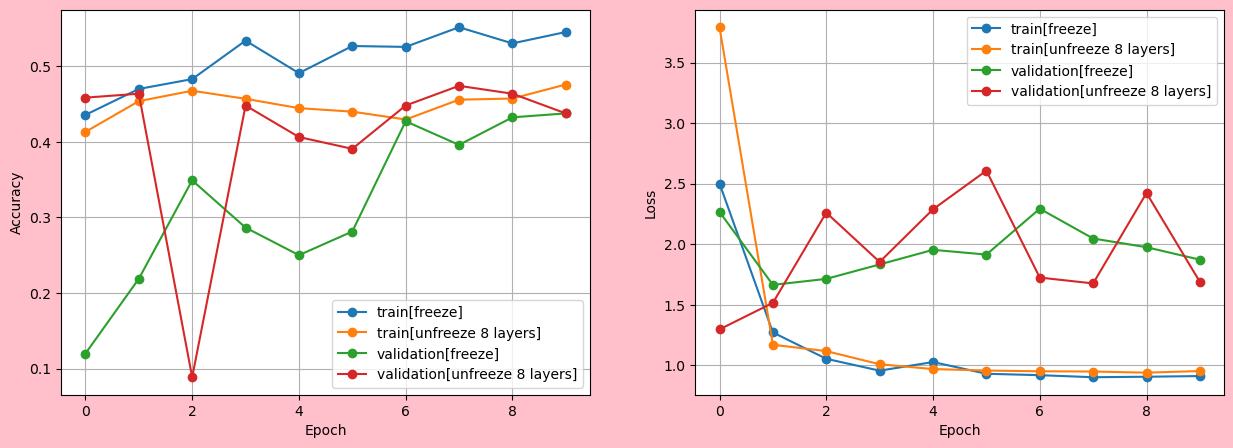

In [15]:
plt.figure(figsize=(15,5), facecolor='pink')
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train[freeze]')
plt.plot(h1.history['accuracy'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_accuracy'], 'o-', label = 'validation[freeze]')
plt.plot(h1.history['val_accuracy'], 'o-', label = 'validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train[freeze]')
plt.plot(h1.history['loss'], 'o-', label='train[unfreeze 8 layers]')

plt.plot(h.history['val_loss'], 'o-', label='validation[freeze]')
plt.plot(h1.history['val_loss'], 'o-', label='validation[unfreeze 8 layers]')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()